# Assessment Graphs
This notebook is for creating graphs based on how modules are assessed and how susceptible they appear to ChatGPT. All module information was collected from publicly available module information on UCD modules in the College of Engineering and Architecture, the method of which can be seen in the Module Scraper Code notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import pathlib as Path
import html5lib
import json

In [2]:
def file_finder(school=None, level=None, givenList=None):
    dir_raw=Path.Path("ModuleInformation")
    
    subdirectory=""
    #Save the file in its desired format
    if level != None:
        subdirectory+= "/Level=%d" %(level)
        
    if school != None:
        subdirectory+= "_School="+school.replace(" ", "-")
        
    if givenList != None:
        subdirectory += "SelectedModules"
        
        
    if len(subdirectory) > 0:
        dir_raw =dir_raw / subdirectory
        

    with open(dir_raw / "assessments.json", 'r') as infile:
        print("Reading from %s" % dir_raw)
        assessments=pd.read_json(infile)
    with open(dir_raw / "descriptors.json", 'r') as infile:
        print("Reading from %s" % dir_raw)
        descriptors=pd.read_json(infile)
    
    return assessments, descriptors

In [3]:
assessments, descriptors = file_finder()

assessments

Reading from ModuleInformation
Reading from ModuleInformation


,Description,Timing,Open Book Exam,Component Scale,Must Pass Component,% of Final Grade,Assessment Type,Scaled % of Final Grade
0,Group Project: Multidisciplinary Group Assignment,Throughout the Trimester,None,Graded,No,50,Group Project,50
1,Examination: End of trimester MCQ,End of trimester MCQ,No,Standard conversion grade scale 40%,No,50,Examination,50
2,Examination: 2 HOUR Examination,2 hour End of Trimester Exam,No,Alternative linear conversion grade scale 40%,No,65,Examination,65
3,"Lab Report: Two in-person labs will be run , w...",Varies over the Trimester,None,Alternative linear conversion grade scale 40%,No,10,Lab Report,10
4,Continuous Assessment: 3 Online quizzes: 1) ci...,Varies over the Trimester,None,Alternative linear conversion grade scale 40%,No,25,Continuous Assessment,25
...,...,...,...,...,...,...,...,...
1267,Assignment: Final report and presentation,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,70,Assignment,280
1268,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,40
1269,Assignment: Development of work plan,Throughout the Trimester,None,Pass/Fail Grade Scale,Yes,20,Assignment,120
1270,Assignment: Industrial Partner Assessment form,Throughout the Trimester,None,Pass/Fail Grade Scale,No,10,Assignment,60


In [4]:
susceptibility={"Assignment" :"susceptible", \
                "Attendance": "not susceptible", \
                "Class Test" : "not susceptible", \
                "Continuous Assessment": "susceptible", \
               "Essay": "susceptible", \
                "Examination": "not susceptible", \
                "Fieldwork": "not susceptible", \
                "Group Project": "susceptible", \
                "Journal": "not susceptible",\
               "Lab Report": "not susceptible", \
                "Multiple Choice Questionnaire": "not susceptible", \
                "Oral Examination": "not susceptible", \
               "Portfolio" : "susceptible",  \
                "Practical Examination": "not susceptible", \
                "Presentation" : "not susceptible", \
                "Project": "susceptible", \
               "Seminar": "not susceptible", \
               "Studio Examination" : "not susceptible",\
               "Assessments worth <2%": "not susceptible"}

In [5]:
def assessment_total_pie(assessments, scaled=True, school=None, level=None, givenList=None):
    assessments=assessments[["Assessment Type", "% of Final Grade", "Scaled % of Final Grade"]]

    #This is the dataset cleaning, so that they are ready for presentation
    assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')
    assessments=assessments.replace("Multiple Choice Questionnaire (Short)", "Multiple Choice Questionnaire")
    assessments=assessments.dropna()
    assessments["Assessment Type"]=assessments["Assessment Type"].astype("category")
    assessments["Susceptiblity"]=assessments["Assessment Type"].apply(lambda x: susceptibility[x])


    assessment_total=assessments.groupby(by="Assessment Type", as_index=False).sum()

    if scaled==True:
        assessment_scale="Scaled % of Final Grade"
    else:
        assessment_scale="% of Final Grade"
        
        
    total=assessment_total[assessment_scale].sum()

    assessment_total["% of Assessment"]=assessment_total[assessment_scale].apply(lambda x: x/total)
    assessment_total["Assessment Type"]=assessment_total["Assessment Type"].cat.add_categories("Assessments worth <2%")
    assessment_total.loc[assessment_total["% of Assessment"] < 0.02, "Assessment Type"] = "Assessments worth <2%"


    assessment_total["Assessment Type"]=assessment_total["Assessment Type"].cat.remove_unused_categories()

    filtered_asses=assessment_total.groupby(by="Assessment Type").sum()
    filtered_asses["Susceptiblity"]=filtered_asses.index.map(lambda x: susceptibility[x])

    sorted_totals=filtered_asses.sort_values(by="% of Assessment", ascending=False)

    fig, ax=plt.subplots(figsize=(15,12))

    #exploded=[0.03, 0, 0.03, 0.03, 0, 0.03, 0.03, 0.03, 0, 0, 0]
    ax.pie(sorted_totals["% of Assessment"], wedgeprops = { 'linewidth' : 0.5, 'edgecolor' : 'grey' }, \
           autopct="%1.1f%%", labels=sorted_totals.index, \
           colors=["gold","mediumseagreen", \
    "gold", "gold", "mediumseagreen",  "gold", "gold", "gold", "mediumseagreen",\
                                                              "mediumseagreen", "mediumseagreen", "mediumseagreen"])

#my_circle=ax.Circle( (0,0), 0.7, color='white')
#p=ax.gcf()

    what="College of Engineering and Architecture"
    if school != None:
        what=school
    if level != None:
        what+= "At Level %d" %level
        
    ax.set_title("Assessment Percentage of Total in the %s" %what, fontsize=20)

In [6]:
def pie_filtered(school=None, level=None, givenList=None, scaled=True):
    assessments, descriptors = file_finder(school=school, level=level, givenList=None)
    
    assessment_total_pie(assessments, scaled, school, level, givenList)

Reading from ModuleInformation
Reading from ModuleInformation


C:\Users\catha\AppData\Local\Temp\ipykernel_40820\850081594.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')


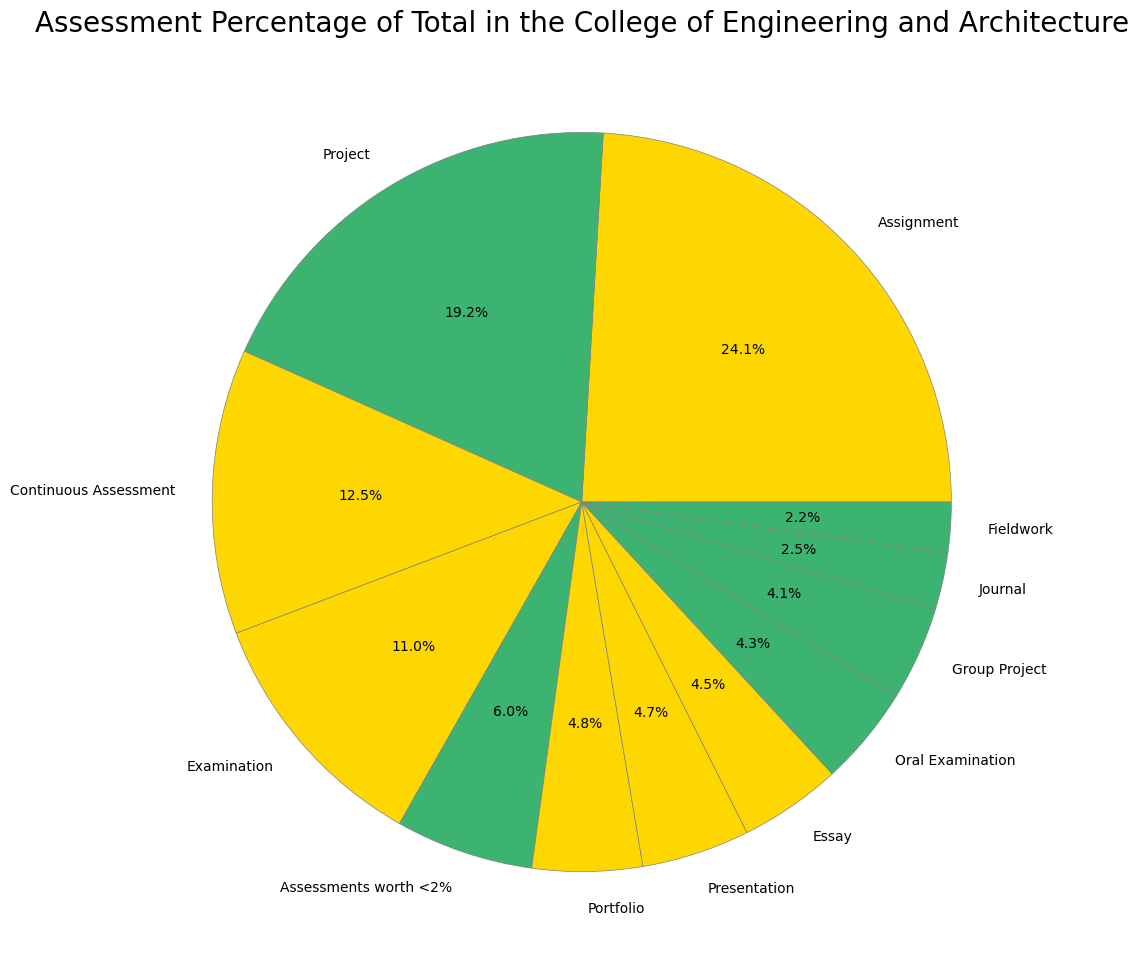

In [7]:
pie_filtered()

Reading from ModuleInformation\_School=Electrical-&-Electronic-Eng
Reading from ModuleInformation\_School=Electrical-&-Electronic-Eng


C:\Users\catha\AppData\Local\Temp\ipykernel_40820\850081594.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')


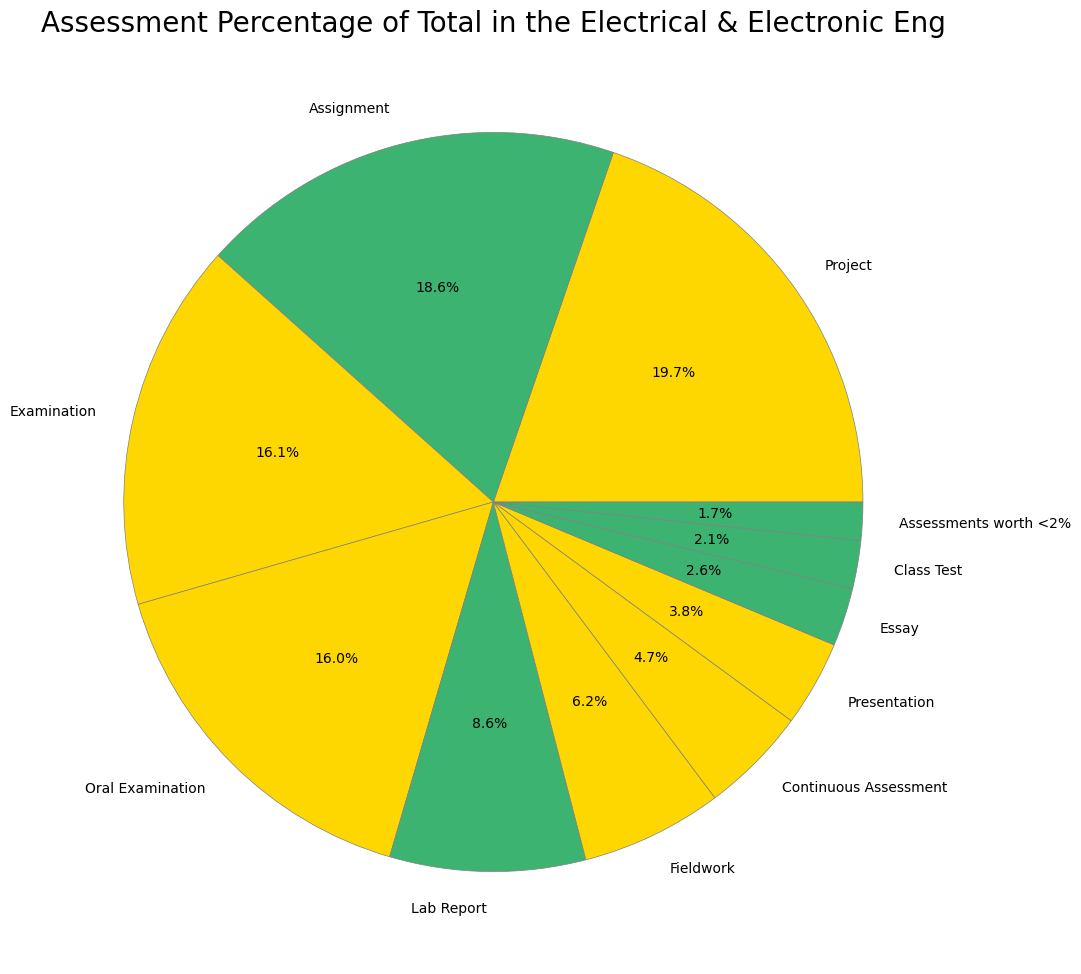

In [8]:
pie_filtered(school="Electrical & Electronic Eng")

Reading from ModuleInformation\_School=Electrical-&-Electronic-Eng
Reading from ModuleInformation\_School=Electrical-&-Electronic-Eng


C:\Users\catha\AppData\Local\Temp\ipykernel_40820\850081594.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')


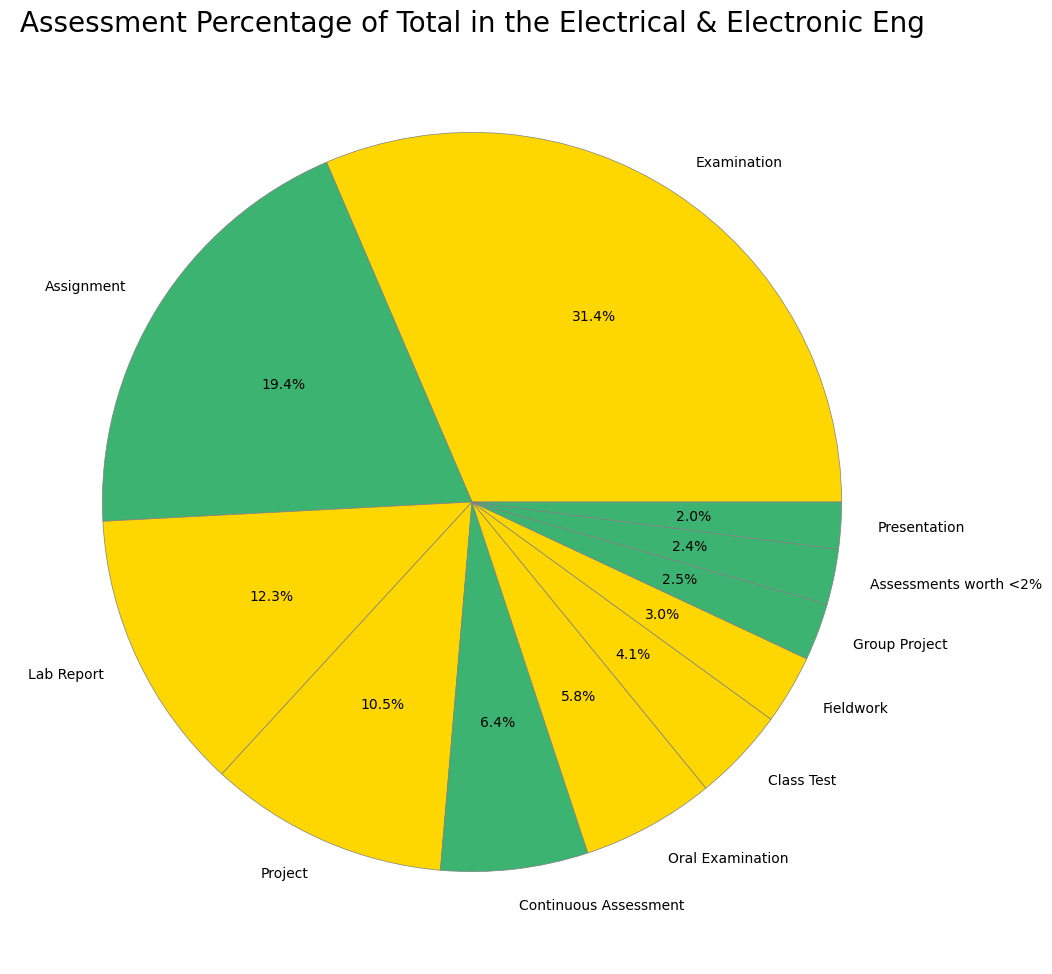

In [9]:
pie_filtered(school="Electrical & Electronic Eng", scaled=False)

In [47]:
def susceptibilty_pie(assessments, scaled=True, school=None, level=None, givenList=None):
    assessments=assessments[["Assessment Type", "% of Final Grade", "Scaled % of Final Grade"]]

    #This is the dataset cleaning, so that they are ready for presentation
    assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')
    assessments=assessments.replace("Multiple Choice Questionnaire (Short)", "Multiple Choice Questionnaire")
    assessments=assessments.dropna()
    assessments["Assessment Type"]=assessments["Assessment Type"].astype("category")
    assessments["Susceptibility"]=assessments["Assessment Type"].apply(lambda x: susceptibility[x])


    #For the pie chart, group by susceptibilty
    assessment_sus=assessments.groupby(by="Susceptibility").sum()
    #For the bar chart, group by assessment type
    assessment_total=assessments.groupby(by="Assessment Type").sum()

    if scaled==True:
        assessment_scale="Scaled % of Final Grade"
    else:
        assessment_scale="% of Final Grade"
        
        
    total=assessment_sus[assessment_scale].sum()

    #Get the percentage of assessments overall for both graphs
    assessment_sus["% of Assessment"]=assessment_sus[assessment_scale].apply(lambda x: x/total)
    assessment_total["% of Assessment"]=assessment_total[assessment_scale].apply(lambda x: x/total)
    #assessment_sus["Assessment Type"]=assessment_sus["Assessment Type"].cat.add_categories("Assessments worth <2%")
    #assessment_sus.loc[assessment_sus["% of Assessment"] < 0.02, "Assessment Type"] = "Assessments worth <2%"


    #assessment_total["Assessment Type"]=assessment_total["Assessment Type"].cat.remove_unused_categories()

    #filtered_asses=assessment_sus.groupby(by="Assessment Type").sum()
    assessment_total["Susceptiblity"]=assessment_total.index.map(lambda x: susceptibility[x])

    sorted_totals=assessment_total.sort_values(by="% of Assessment", ascending=False)

    fig, (ax, bx)=plt.subplots(nrows=2, figsize=(15,12))

    #exploded=[0.03, 0, 0.03, 0.03, 0, 0.03, 0.03, 0.03, 0, 0, 0]
    ax.pie(assessment_sus["% of Assessment"], wedgeprops = { 'linewidth' : 0.5, 'edgecolor' : 'grey' }, \
           autopct="%1.1f%%", labels=assessment_sus.index, \
           colors=["mediumseagreen", "gold"])

    bx.bar(sorted_totals.index, sorted_totals["% of Assessment"], edgecolor="grey", \
           color=["mediumseagreen", "gold", \
"gold", "mediumseagreen", "mediumseagreen", "gold", "gold",  "mediumseagreen", "gold", "gold", "gold", "mediumseagreen",\
                                                                                       "mediumseagreen", "mediumseagreen", \
                                                "mediumseagreen", "gold", "mediumseagreen", "mediumseagreen"] )
    
    #Set the options for the axes
    bx.tick_params(axis='y', labelsize=16)
    bx.tick_params(axis='x', rotation=90, labelsize=14)
#ax.legend(fontsize=20)
    bx.set_xlabel("Assessment Type", fontsize=18)
    bx.set_ylabel("% of Assessment",fontsize=18)
#Add the date lines for context
    bx.set_title("Assessment Type Percentage", fontsize=20)
    
#my_circle=ax.Circle( (0,0), 0.7, color='white')
#p=ax.gcf()

    what="College of Engineering and Architecture"
    if school != None:
        what=school
    if level != None:
        what+= "At Level %d" %level
        
    fig.suptitle("Assessment Susceptibilty to ChatGPT in the %s" %what, fontsize=20)

In [48]:
def susceptibility_graphs(school=None, level=None, givenList=None, scaled=True):
    assessments, descriptors = file_finder(school=school, level=level, givenList=None)
    
    susceptibilty_pie(assessments, scaled, school, level, givenList)

Reading from ModuleInformation
Reading from ModuleInformation


C:\Users\catha\AppData\Local\Temp\ipykernel_40820\1803480773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assessments["% of Final Grade"]=pd.to_numeric(assessments["% of Final Grade"], errors='coerce')


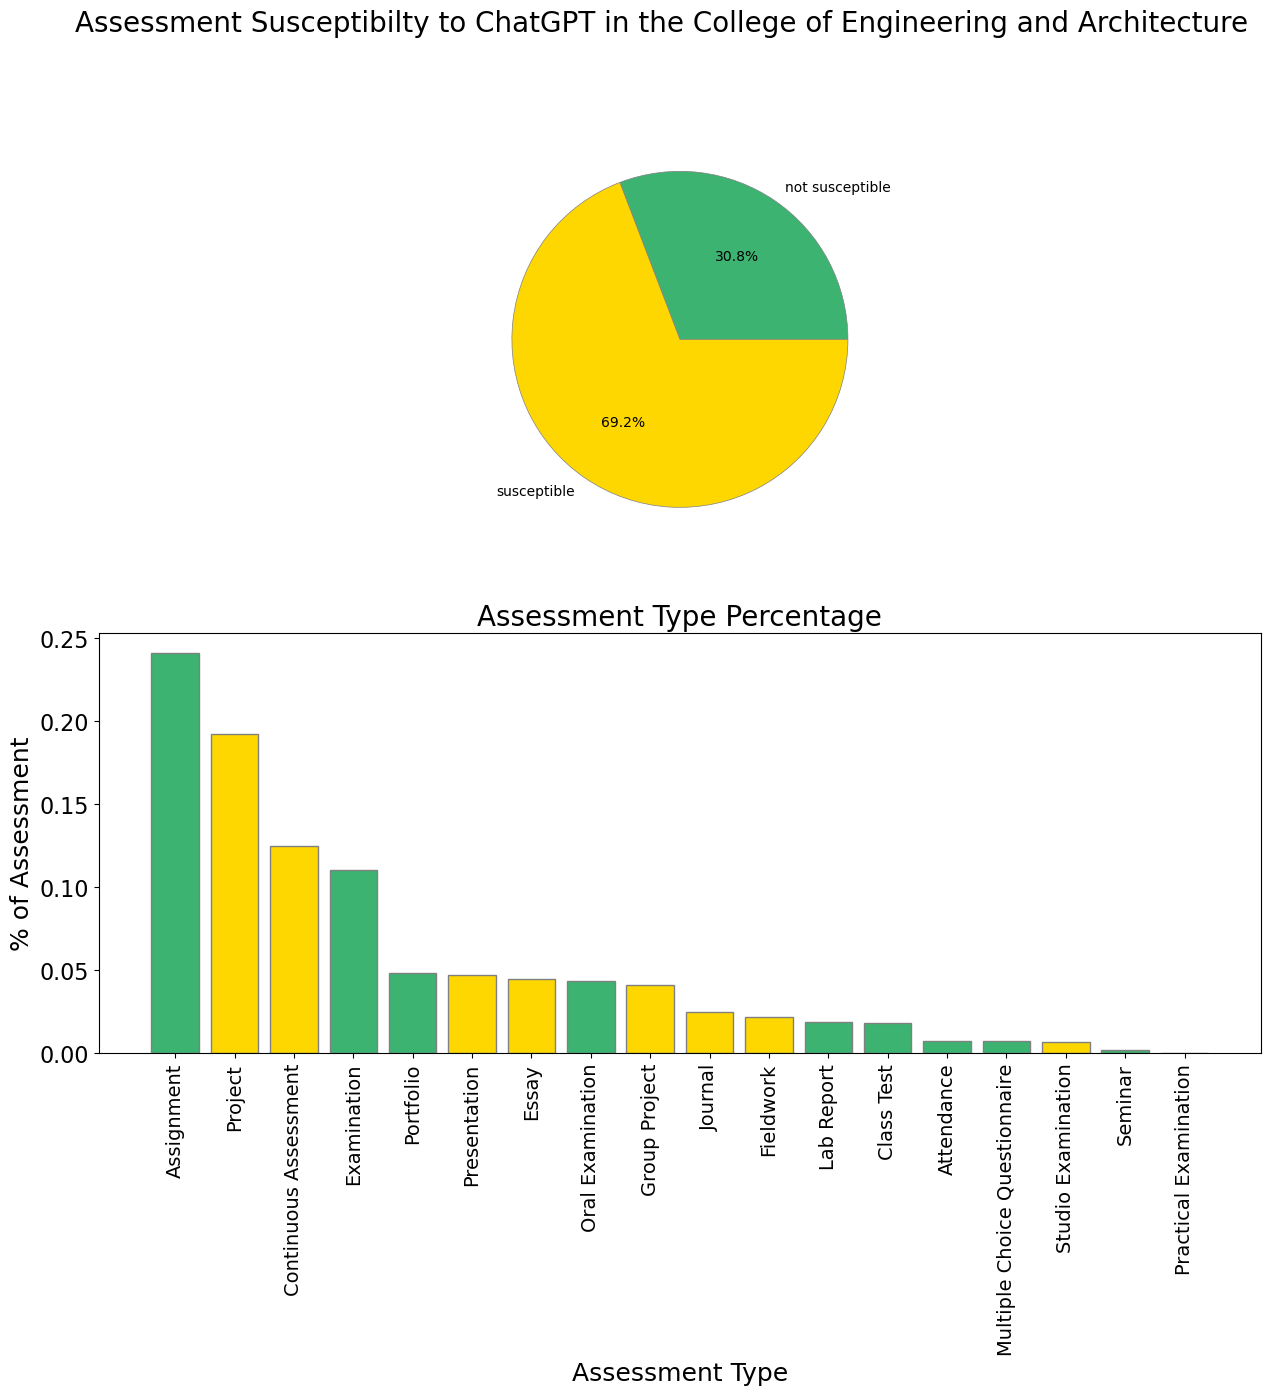

In [49]:
susceptibility_graphs()